# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


. [Correlations](#correlations)


In [1]:
# Import necessary libraries
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns


## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [2]:
# Load the data

url = "https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.nao.cdas.z500.19500101_current.csv"
df = pd.read_csv(url)

# make time nicer
df['time'] = pd.to_datetime(df[['year','month','day']]) #make a nicer date
df = df.set_index('time')

#features: seasons, decade, more decades?

#seasons
#winter: 11-4 (positiv), summer: 5-10 (negativ) -> defined like this by looking in the seasonality
# Define winter and summer using +1 / -1
winter_months = {11, 12, 1, 2, 3, 4}
df['season_flag'] = df['month'].apply(lambda m: 1 if m in winter_months else -1)
# Put 'season_flag' right after 'month'
df.insert(3, 'season_flag', df.pop('season_flag'))

#decade
df['decade'] = df['year'] // 10 * 10
df.insert(4, 'decade', df.pop('decade'))

# drop day, year
df.drop(columns=['day', 'year'], inplace=True)

#make xarray out of this
ds = xr.Dataset.from_dataframe(df)

# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head())

Number of samples: 27716
Number of features: 4
Example data:
            month  season_flag  decade  nao_index_cdas
time                                                  
1950-01-01      1            1    1950           0.365
1950-01-02      1            1    1950           0.096
1950-01-03      1            1    1950          -0.416
1950-01-04      1            1    1950          -0.616
1950-01-05      1            1    1950          -0.261


Maybe month and season is doing the same, rather take only season?

## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values


,0
month,0
season_flag,0
decade,0
nao_index_cdas,2


In [45]:
# Handling missing values
# Example: Replacing NaN values with the mean value of the column
# df.fillna(df.mean(), inplace=True)

# Your code for handling missing values goes here

#fill NaNs with mean of theire neighboring values?

def fill_nans_weighted(ds, dim, n=3, weights=None):
    """
    Fill NaNs in an xarray Dataset/DataArray using a weighted mean of
    n values before and after along dimension `dim`.

    Parameters
    ----------
    ds : xr.DataArray or xr.Dataset
        Input data with NaNs to fill.
    dim : str
        Dimension along which to apply the interpolation (e.g. "time").
    n : int
        Number of values before and after to use.
    weights : array-like or None
        Weights for the window. Should have length (2*n + 1).
        If None, all weights = 1 (simple mean).

    Returns
    -------
    xr.DataArray or xr.Dataset
        Data with NaNs filled.
    """

    window = 2 * n + 1

    # default: equal weights
    if weights is None:
        weights = np.ones(window)
    else:
        weights = np.asarray(weights)
        if len(weights) != window:
            raise ValueError("weights must have length 2*n + 1")

    # Normalize weights
    weights = weights / weights.sum()

    # Rolling window with centered window
    rolled = ds.rolling({dim: window}, center=True).construct("window")

    # Weighted mean ignoring NaNs
    filled = (rolled * xr.DataArray(weights, dims=["window"])).sum("window")

    # Replace NaNs only
    return ds.fillna(filled)

ds = fill_nans_weighted(ds, dim='time', n=3, weights=None)

# different smoothed versions --> maybe better after nan treating
ds_weekly  = ds.rolling(time=7, center=True).mean()

ds_monthly = ds.rolling(time=30, center=True).mean()
ds_monthly


ds_yearly = ds.rolling(time=365, center=True).mean()
ds_yearly

ds_decade = ds.rolling(time=365*10, center=True).mean()
ds_decade

<xarray.Dataset> Size: 1MB
Dimensions:         (time: 27716)
Coordinates:
  * time            (time) datetime64[ns] 222kB 1950-01-01 ... 2025-11-18
Data variables:
    month           (time) float64 222kB nan nan nan nan nan ... nan nan nan nan
    season_flag     (time) float64 222kB nan nan nan nan nan ... nan nan nan nan
    decade          (time) float64 222kB nan nan nan nan nan ... nan nan nan nan
    nao_index_cdas  (time) float64 222kB nan nan nan nan nan ... nan nan nan nan

In [48]:
#have the monthly data also as panda for some of the following tasks
df_monthly = ds_monthly.to_dataframe()
df_monthly

,month,season_flag,decade,nao_index_cdas
time,,,,
1950-01-01,NaN,NaN,NaN,NaN
1950-01-02,NaN,NaN,NaN,NaN
1950-01-03,NaN,NaN,NaN,NaN
1950-01-04,NaN,NaN,NaN,NaN
1950-01-05,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-11-14,NaN,NaN,NaN,NaN
2025-11-15,NaN,NaN,NaN,NaN
2025-11-16,NaN,NaN,NaN,NaN


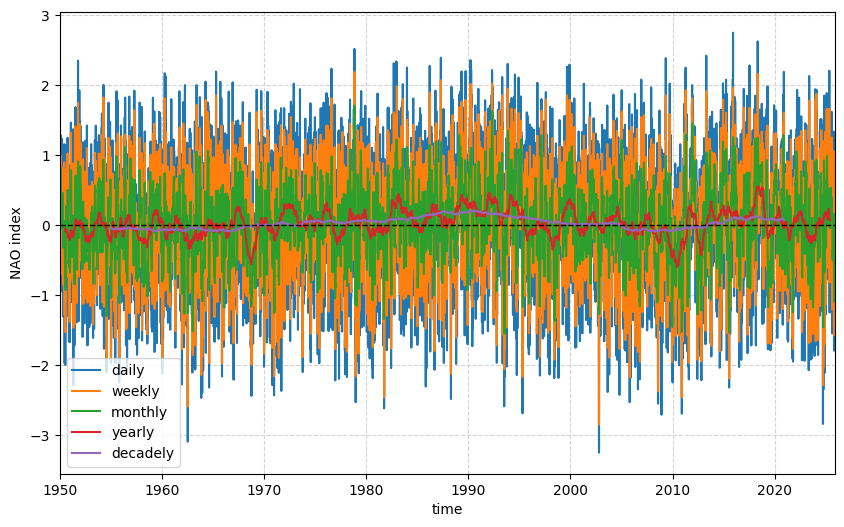

In [7]:
#plot data to see which smoothing to take -> monthly (30days)
#also selection of features done whith this, decadal stuff seems to be important, further check seasonality
plt.figure(figsize=(10,6))
plt.plot(ds.time, ds.nao_index_cdas, label = 'daily')
plt.plot(ds_weekly.time, ds_weekly.nao_index_cdas, label = 'weekly')
plt.plot(ds_monthly.time, ds_monthly.nao_index_cdas, label='monthly')
plt.plot(ds_yearly.time, ds_yearly.nao_index_cdas, label = 'yearly')
plt.plot(ds_decade.time, ds_decade.nao_index_cdas, label = 'decadely')
plt.xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2025-11-21')) ###!!! needs to be corrected to today!!!
plt.hlines(y=0, xmin=pd.Timestamp('1950-01-01'), xmax=pd.Timestamp('2025-11-19'), linestyle='--', color='black', linewidth=1)
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlabel('time')
plt.ylabel('NAO index')
plt.legend()
plt.show()
#plt.xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('1990-01-01'))

/usr/local/lib/python3.12/dist-packages/xarray/structure/concat.py:637: UserWarning: No index created for dimension month because variable month is not a coordinate. To create an index for month, please first call `.set_coords('month')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


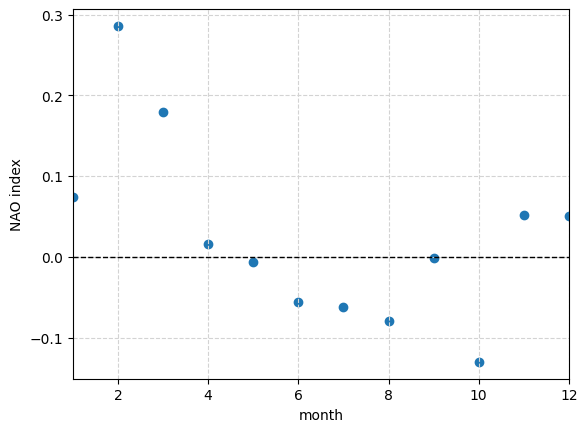

In [9]:
#is there a seasonality? -> yes, take seasonality also as feature
climatology = ds.groupby("time.month").mean("time")

plt.scatter(climatology.month, climatology.nao_index_cdas)
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlabel('month')
plt.ylabel('NAO index')
plt.hlines(y=0, xmin=1, xmax=12, linestyle='--', color='black', linewidth=1)
plt.xlim(1,12)
plt.show()

## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


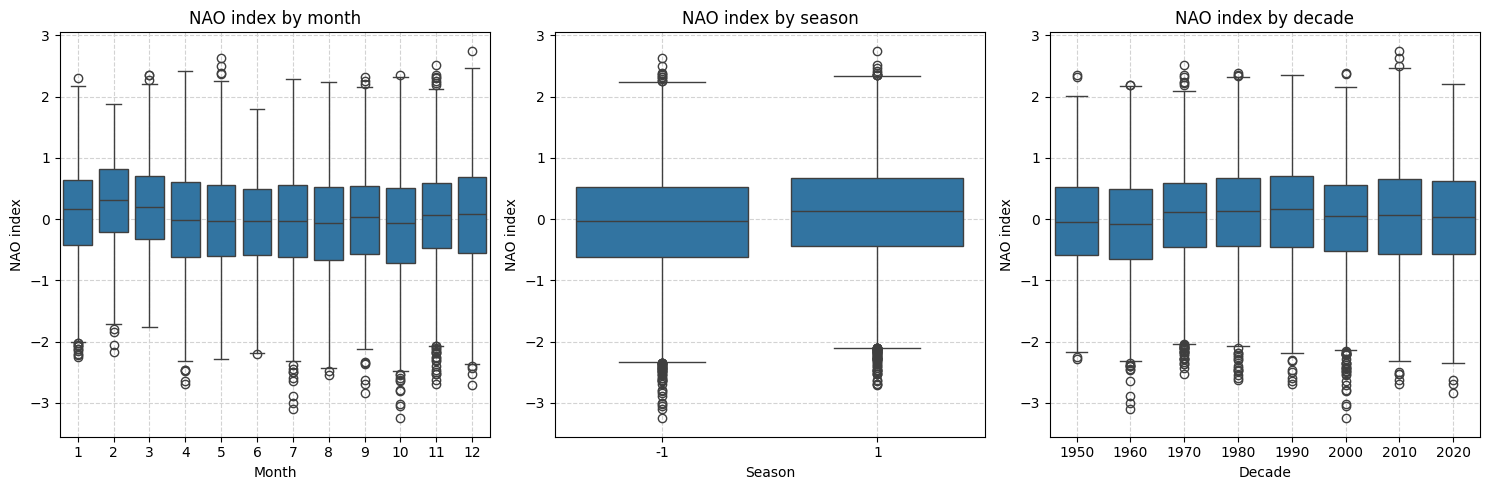

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df, x='month', y='nao_index_cdas', ax=ax[0])
ax[0].set_title("NAO index by month")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("NAO index")

sns.boxplot(data=df, x='season_flag', y='nao_index_cdas', ax=ax[1])
ax[1].set_title("NAO index by season")
ax[1].set_xlabel("Season")
ax[1].set_ylabel("NAO index")

sns.boxplot(data=df, x='decade', y='nao_index_cdas', ax=ax[2])
ax[2].set_title("NAO index by decade")
ax[2].set_xlabel("Decade")
ax[2].set_ylabel("NAO index")

for i in range(0,3):
    ax[i].grid(linestyle = '--', color = 'lightgrey')
plt.tight_layout()
plt.show()

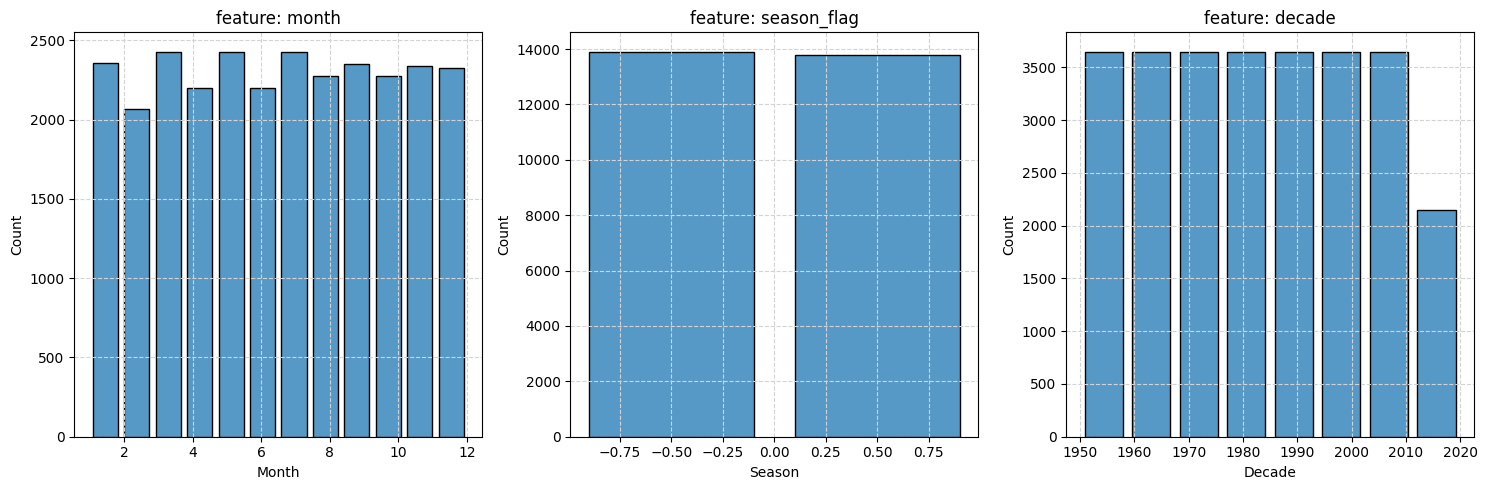

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(ds_monthly.month, bins=12, kde=False,shrink=0.8, label = 'data', ax=ax[0])
ax[0].set_title("feature: month")
ax[0].set_xlabel("Month")

sns.histplot(ds_monthly.season_flag, bins=2, kde=False,shrink=0.8, label = 'data', ax=ax[1])
ax[1].set_title("feature: season_flag")
ax[1].set_xlabel("Season")

sns.histplot(ds_monthly.decade, bins=8, kde=False,shrink=0.8, label = 'data', ax=ax[2])
ax[2].set_title("feature: decade")
ax[2].set_xlabel("Decade")

for i in range(0,3):
    ax[i].grid(linestyle = '--', color = 'lightgrey')
plt.tight_layout()
plt.show()

The data is up to today, by this the current decade (and slightly also the current season) is underrepresented.
The month have different numbers of days, summing that up over 70 years leads to underrepresentation of shorter moth most pronounced for february.

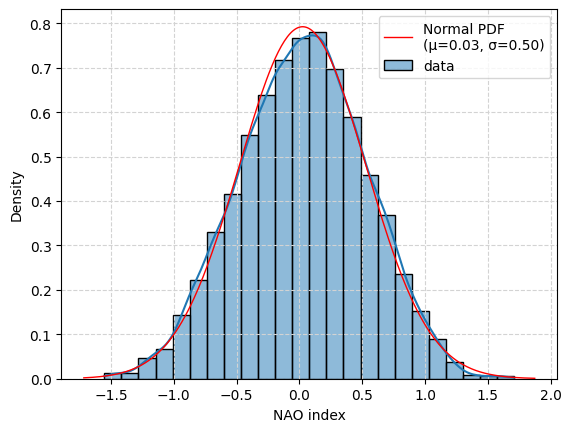

Skewness: -0.05767370574144814


In [29]:
# Example: Plotting histograms of all numerical features
#plt.hist(ds_monthly.nao_index_cdas,bins=24,density=True)
sns.histplot(ds_monthly.nao_index_cdas, bins=24, kde=True, stat="density", label = 'data')
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlabel('NAO index')

from scipy.stats import norm
# Compute normal distribution curve
x = ds_monthly.nao_index_cdas
mu = x.mean()
sigma = x.std()
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 300)
yy = norm.pdf(xx, mu, sigma)

# Plot normal curve
plt.plot(xx, yy, 'r-', linewidth=1, label=f'Normal PDF \n(μ={mu:.2f}, σ={sigma:.2f})')

plt.legend(loc = 'upper right')
plt.show()

# Compute skewness
from scipy.stats import skew
sk = skew(ds_monthly.nao_index_cdas.values, nan_policy='omit')
print("Skewness:", sk)

## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


Summary Statistics:

count    27718.000000
mean         0.025182
std          0.816508
min         -3.254000
25%         -0.531000
50%          0.057000
75%          0.605000
max          2.751319
Name: nao_index_cdas, dtype: float64




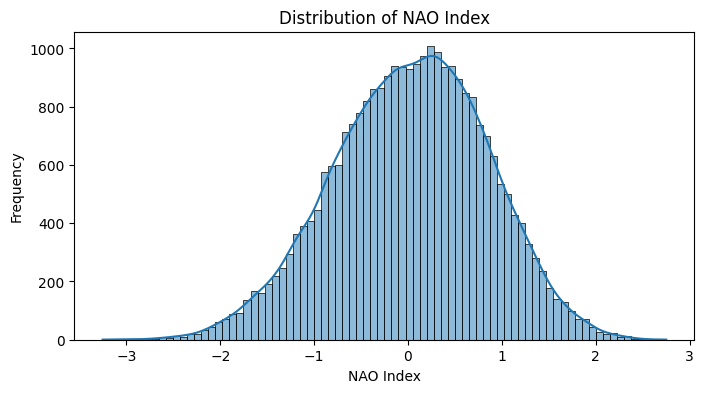

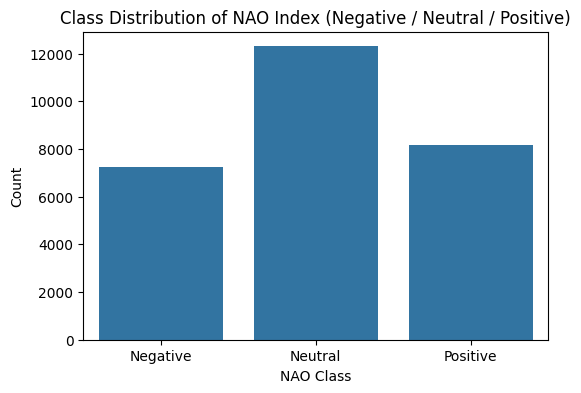


Class Counts:
nao_class
Neutral     12301
Positive     8167
Negative     7250
Name: count, dtype: int64




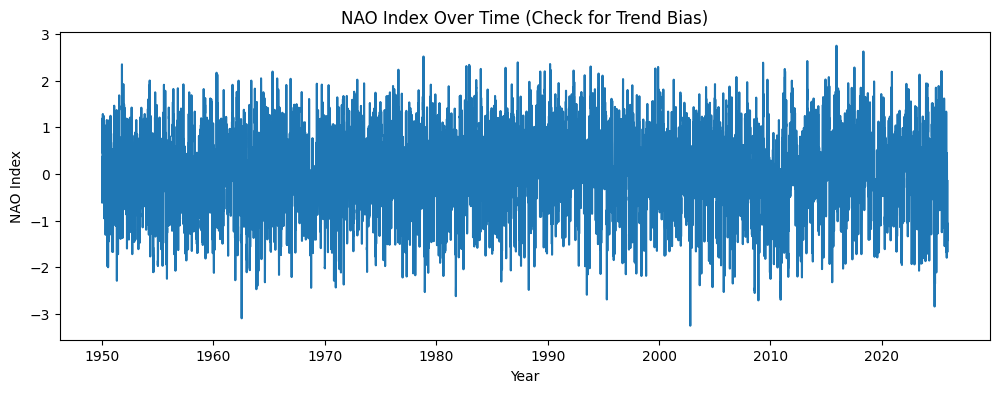

In [1]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.nao.cdas.z500.19500101_current.csv"
df = pd.read_csv(url)

# 1. Basic Summary Statistics (checks for skew, imbalance, outliers)
print("Summary Statistics:\n")
print(df['nao_index_cdas'].describe())
print("\n")

# 2. Check Distribution Shape (important for bias in regression)
plt.figure(figsize=(8, 4))
sns.histplot(df['nao_index_cdas'], kde=True)
plt.title("Distribution of NAO Index")
plt.xlabel("NAO Index")
plt.ylabel("Frequency")
plt.show()

# 3. Convert Continuous Target into Classes (for class imbalance check)
df['nao_class'] = pd.cut(
    df['nao_index_cdas'],
    bins=[-999, -0.5, 0.5, 999],
    labels=['Negative', 'Neutral', 'Positive']
)


# 4. Class Imbalance Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='nao_class', data=df)
plt.title("Class Distribution of NAO Index (Negative / Neutral / Positive)")
plt.xlabel("NAO Class")
plt.ylabel("Count")
plt.show()

# Optional: Print class counts
print("\nClass Counts:")
print(df['nao_class'].value_counts())
print("\n")

# 5. Temporal Bias Check (climate data often shifts over decades)
df['date'] = pd.to_datetime(df[['year','month','day']])

plt.figure(figsize=(12, 4))
sns.lineplot(x='date', y='nao_index_cdas', data=df)
plt.title("NAO Index Over Time (Check for Trend Bias)")
plt.xlabel("Year")
plt.ylabel("NAO Index")
plt.show()

## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


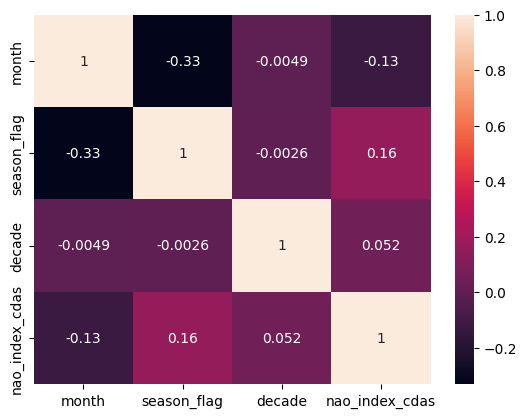

In [47]:
# Example: Plotting a heatmap to show feature correlations
correlation_matrix = df_monthly.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()


Season and Month correlate, since Season is 'made' by looking at the monthly climatology.